In [ ]:
import os
import subprocess
import time
import re
import random
import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import eig
from sympy import init_printing, Matrix


In [77]:
# Environment variables
topology_file="untitled.imn"
bandwidth="100000000"
scenario_id="i2009"
delay="1000"
fluxes="1"

# Define the topology
links = [
    "switch1:pc1",
    "switch1:pc3",
    "switch1:pc2",
    "switch1:pc4",
]

In [97]:
# Inicializar impressão simbolica
init_printing()

# Matriz de transição da cadeia de Markov
# P[i][j] representa a probabilidade de ir do estado i para o estado j.
# Por exemplo, P[0][1] = 0.2 significa que há 20% de chance de ir de HIGH para ZERO.
P = np.array([
    [0.7, 0.2, 0.1],   # Transições a partir do estado 0 (HIGH)
    [0.1, 0.8, 0.1],   # Transições a partir do estado 1 (ZERO)
    [0.05, 0.15, 0.8]  # Transições a partir do estado 2 (LOW)
])


# Converter para matriz simbólica do sympy
P_sym = Matrix(P_np)

print("Matriz de transição P:")
# Exibir a matriz simbolicamente
P_sym


Matriz de transição P:


⎡0.7   0.2   0.1⎤
⎢               ⎥
⎢0.1   0.8   0.1⎥
⎢               ⎥
⎣0.05  0.15  0.8⎦

In [78]:
def run_iperf_and_capture_data(client_pc, server_ip, scenario_id, size="100M", parallel="1", interval="1", duration=10):

    client_pc_str = str(client_pc)
    server_ip_str = str(server_ip)
    scenario_id_str = str(scenario_id)
    size_str = str(size)
    parallel_str = str(parallel)
    interval_str = str(interval)
    duration_str = str(duration)

    cmd = [
        "sudo", "himage", f"{client_pc_str}@{scenario_id_str}",
        "iperf", "-c", server_ip_str, "-n", size_str, "-P", parallel_str, "-i", interval_str, "-t", duration_str
    ]

    print(f"Running TCP test from {client_pc_str} to {server_ip_str} for {duration_str} seconds...")

    process = subprocess.run(cmd, capture_output=True, text=True)
    output = process.stdout

    # Regex fixa para MBytes (não importa a unidade que aparece, pois vamos ajustar depois)
    pattern = re.compile(
        r"\[\s*\d+\]\s+([\d.]+)-([\d.]+)\s+sec\s+([\d.]+)\s+MBytes\s+([\d.]+)\s+Mbits/sec"
    )
    results = pattern.findall(output)

    if results:
        time_points = []
        transfers = []
        bandwidths = []

        # Decide o fator de correção com base no sufixo do parâmetro 'size'
        if size_str.upper().endswith("K"):
            divisor = 1024
        elif size_str.upper().endswith("M"):
            divisor = 1
        elif size_str.upper().endswith("G"):
            divisor = 1 / 1024
        else:
            print(f"Warning: unidade não reconhecida no parâmetro 'size': {size_str}")
            divisor = 1  # default (assume MBytes)

        for start, end, transfer, bandwidth in results:
            time_points.append(float(end))
            transfers.append(float(transfer) / divisor)
            bandwidths.append(float(bandwidth) / divisor)

        return time_points, transfers, bandwidths
    else:
        print("Nenhum resultado encontrado na saída do iperf.")
        print("Saída bruta:")
        print(output)
        return [], [], []


In [79]:
# link configuration
def configure_links(bandwidth, delay, loss, scenario_id):
    for link in links:
        subprocess.run(
            ["sudo", "vlink", "-bw", bandwidth, "-dly", delay, f"{link}@{scenario_id}"],
            stdout=subprocess.DEVNULL
        )

    time.sleep(1)

    # Check status
    for link in links:
        subprocess.run(
            ["sudo", "vlink", "-s", f"{link}@{scenario_id}"]
        )

In [80]:
# Configure computers...
def configure_computers(scenario_id):
    # Start iperf servers
    subprocess.Popen(
        ["sudo", "himage", f"pc2@{scenario_id}", "iperf", "-s"],
        stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL
    )
    subprocess.Popen(
        ["sudo", "himage", f"pc4@{scenario_id}", "iperf", "-s"],
        stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL
    )

In [81]:
def starts_simulation(scenario_id):
    result = subprocess.run(
        ["sudo", "imunes", "-d", "-b", "-e", scenario_id, topology_file],
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True
    )
    print("STDOUT:\n", result.stdout)
    print("STDERR:\n", result.stderr)
    
def stop_simulation(scenario_id):
    subprocess.run(
        ["sudo", "imunes", "-b", "-e", scenario_id], 
        stdout=subprocess.DEVNULL
    )
    

In [82]:
def generate_bandwidth_sequence(length=30):
    states = [50, 0, 10]
    probabilities = [0.1, 0.2, 0.7]
    return random.choices(states, weights=probabilities, k=length)


In [83]:
def mbps_to_bytes_per_sec(mbps):
    # Converte megabits por segundo (Mbps) em bytes por segundo
    # 1 Mbps = 1.000.000 bits = 125.000 bytes
    return int((mbps * 1_000_000) / 8)

def run_markov_iperf(client_pc, server_ip, scenario_id, interval=1, duration_per_state=8, num_transitions=20):
    # Define os estados possíveis de largura de banda e suas probabilidades de ocorrência
    states = ["HIGH", "ZERO", "LOW"]
    probabilities = [0.1, 0.2, 0.7]

    # Mapeia cada estado a um valor de largura de banda em Mbps
    bandwidth_map = {
        "HIGH": 50,   # Alta largura de banda
        "ZERO": 0,    # Nenhuma largura de banda
        "LOW": 10     # Baixa largura de banda
    }

    # Listas para armazenar os dados de saída
    time_points = []   # Momentos no tempo
    transfers = []     # Transferências em MB
    bandwidths = []    # Largura de banda observada em Mbps
    state_map = []     # Estado associado a cada ponto no tempo

    current_time = 0  # Marca o tempo decorrido total

    # Executa a simulação de transições de estados num processo de Markov
    for i in range(num_transitions):
        # Escolhe aleatoriamente um estado com base nas probabilidades
        state = random.choices(states, probabilities)[0]
        bandwidth = bandwidth_map[state]
        state_index = states.index(state)  # Índice numérico do estado

        print(f"\nTransição {i+1}/{num_transitions} - Estado: {state}, Bandwidth: {bandwidth} Mbps")

        # Configura os links se a largura de banda for maior que 0
        if bandwidth > 0:
            bw_str = f"{bandwidth}M"
            delay_str = "1ms"
            loss_str = "0%"
            configure_links(bw_str, delay_str, loss_str, scenario_id)

        # Determina o tamanho do buffer para o iperf com base na largura de banda
        if bandwidth == 50:
            size = "50M"
        elif bandwidth == 10:
            size = "10M"
        elif bandwidth == 0:
            size = "1K" 

        # Executa o iperf e captura os dados de tempo, transferência e banda
        t_pts, trans, bwds = run_iperf_and_capture_data(
            client_pc=client_pc,
            server_ip=server_ip,
            scenario_id=scenario_id,
            duration=duration_per_state,
            interval=interval,
            size=size
        )

        # Mostra os dados capturados no console
        print("Tempo (s):", t_pts)
        print("Transferências (MB):", trans)
        print("Bandwidths (Mbps):", bwds)

        # Ajusta os tempos relativos para o tempo total decorrido
        t_pts = [current_time + t for t in t_pts]
        current_time += duration_per_state

        # Armazena os dados da iteração atual nas listas de saída
        time_points.extend(t_pts)
        transfers.extend(trans)
        bandwidths.extend(bwds)
        state_map.extend([state_index] * len(bwds))  # Repete o estado para cada amostra de largura de banda

        # Aguarda 1 segundo entre transições para evitar sobreposição
        time.sleep(1)

    # Retorna os dados coletados ao longo das transições
    return time_points, transfers, bandwidths, state_map


In [84]:
def run_imunes_simulation(
    topology_file="untitled.imn",
    bandwidth="10000000",
    scenario_id="i2002",
    delay="10000",
    fluxes="1"
):
    # Start simulation
    print("=" * 56)
    print(f"Starting IMUNES simulation with scenario ID: {scenario_id}")
    starts_simulation(scenario_id)
    time.sleep(3)

    # Configure links
    print("=" * 56)
    print("Simulation started, configuring links...")
    configure_links(bandwidth, delay, 0, scenario_id)
    time.sleep(1)

    # Configure computers
    print("=" * 56)
    print("Configuring computers...")
    configure_computers(scenario_id)
    time.sleep(1)

    # Run iperf tests using Markov-based traffic generation
    print("=" * 56)
    print("Running Markov-based iperf traffic generation...")
    time_pts, transfers, bandwidths, state_map = run_markov_iperf(
        client_pc="pc3",
        server_ip="10.0.0.20",
        scenario_id=scenario_id,
        interval=1,
        duration_per_state=8,
        num_transitions=20

    )

    # Stop simulation
    print("=" * 56)
    print(f"Stopping IMUNES simulation with scenario ID: {scenario_id}")
    stop_simulation(scenario_id)
    print("Simulation stopped")

    return time_pts, transfers, bandwidths, state_map


In [85]:

def plot_iperf_graph(time_points, transfers, bandwidths, title="Largura de Banda para cada interação"):
    if not time_points or not bandwidths:
        print("Vetores vazios, nada a plotar.")
        return

    plt.figure(figsize=(16, 9))
    plt.plot(time_points, bandwidths, marker='o', linestyle='-', color='blue', label="Largura de Banda (Mbps)")
    plt.plot(time_points, transfers, marker='x', linestyle='--', color='red', label="Transferência (MB)")
    plt.title(title)
    plt.xlabel("Tempo (Interação)")
    plt.ylabel("Largura de Banda (Mbps)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [86]:
time_pts, transfers, bandwidths, state_map = run_imunes_simulation(
    topology_file=topology_file,
    bandwidth=bandwidth,
    scenario_id=scenario_id,
    delay=delay,
    fluxes=fluxes
)

Starting IMUNES simulation with scenario ID: i2009
STDOUT:
 Using experiment ID 'i2009'.
Preparing for initialization...
Instantiating VIRTUALIZED nodes...

                                                
> 0/4 
                                                
> 1/4 
                                                
> 2/4 
                                                
> 3/4 
                                                
> 4/4 
Waiting for 4 VIRTUALIZED node(s) to start...

                                                
> 0/4 
                                                
> 1/4 
                                                
> 2/4 
                                                
> 2/4 
                                                
> 3/4 
                                                
> 4/4 
                                                
> 4/4 
Setting up namespaces for all nodes...

                                                
> 0/5 
                            

Time points: 168
Transfers: 168
Bandwidths: 168
State map: 168


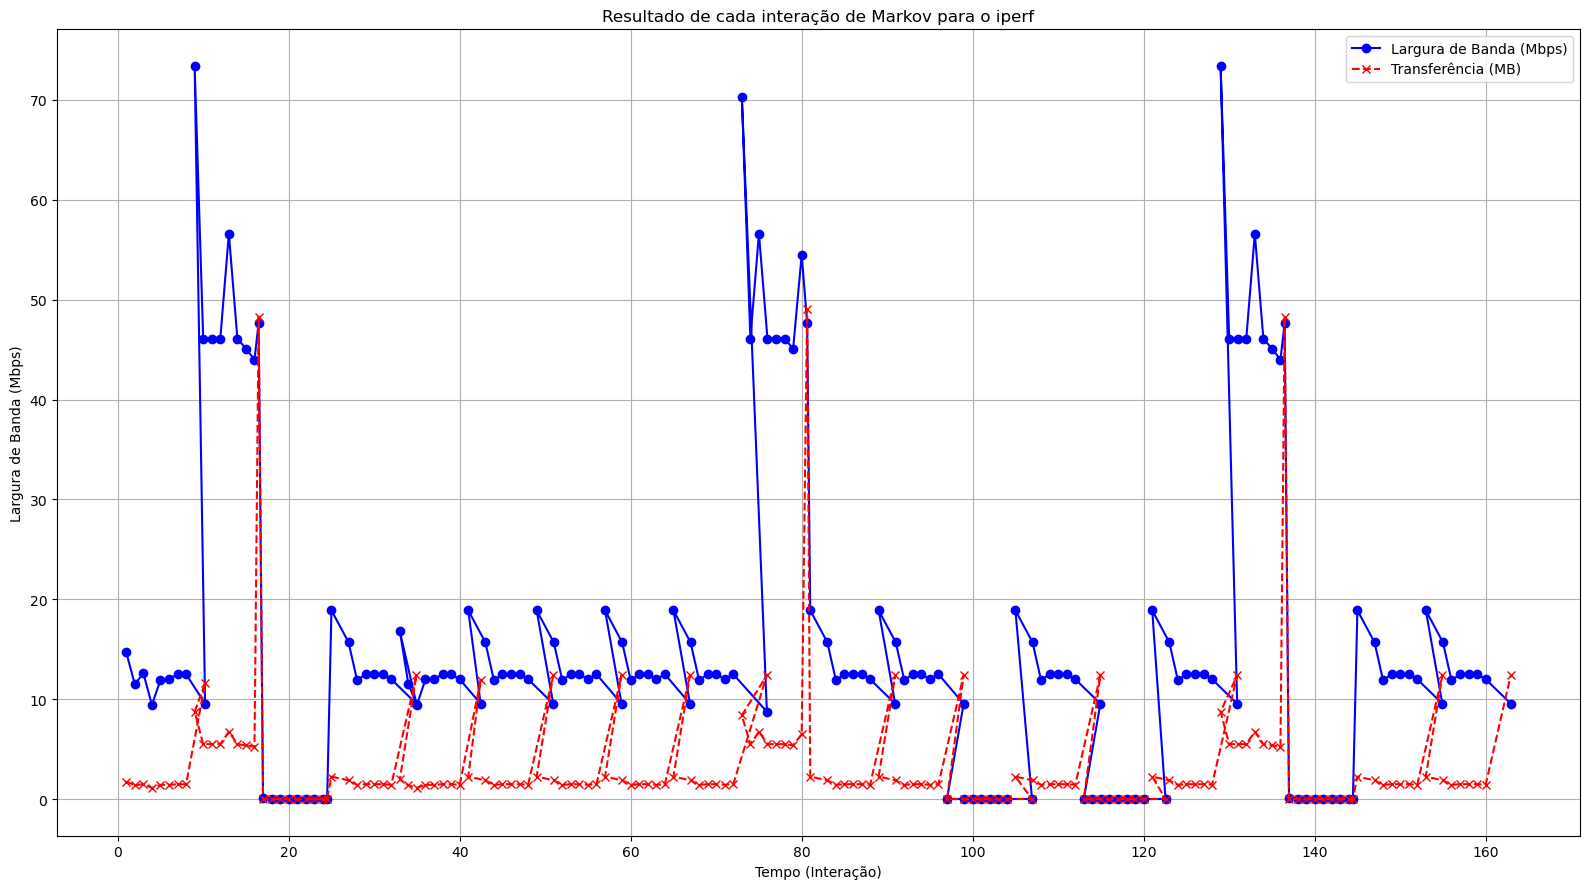

In [87]:
# imprime o tamanho dos vetores
print(f"Time points: {len(time_pts)}")
print(f"Transfers: {len(transfers)}")
print(f"Bandwidths: {len(bandwidths)}")
print(f"State map: {len(state_map)}")

plot_iperf_graph(
        time_points=time_pts,
        transfers=transfers,
        bandwidths=bandwidths,
        title="Resultado de cada interação de Markov para o iperf"
)

In [98]:
# Taxas de tráfego teóricas (em Mbps)
bandwidth_theoretical = [50.0, 0.001, 10.0]  

# Cálculo das probabilidades estacionárias
# Essa função retorna o vetor de probabilidades estacionárias da cadeia de Markov,
def stationary_distribution(P):
    # Calcula os autovalores e autovetores da transposta da matriz P
    evals, evecs = eig(P.T)  
    idx = np.argmin(np.abs(evals - 1.0))

    # Pega o autovetor correspondente (estacionário) e converte para valores reais  
    stationary = np.real(evecs[:, idx]) 
    stationary /= stationary.sum()

    return stationary

pi = stationary_distribution(P)

# Cálculo da vazão média teórica
throughput_theoretical = np.dot(pi, bandwidth_theoretical)

# Cálculo da média observada por estado
n_states = len(bandwidth_theoretical)  
measured_means = [] 

# Para cada estado, calcula a média dos valores de banda medidos
# Esse bloco calcula a vazão média observada experimentalmente para cada estado da cadeia de Markov.
for s in range(n_states):
    indices = [i for i, st in enumerate(state_map) if st == s] 

    # Pega os índices dos estados correspondentes
    state_bw = [bandwidths[i] for i in indices]  
    measured_means.append(np.mean(state_bw))

# Vazão média observada
throughput_observed = np.dot(pi, measured_means)

Distribuição estacionária: [0.20833333 0.45833333 0.33333333]
Vazão média teórica: 13.750458333333334 Mbps
Vazão média observada: 14.840250598014954 Mbps


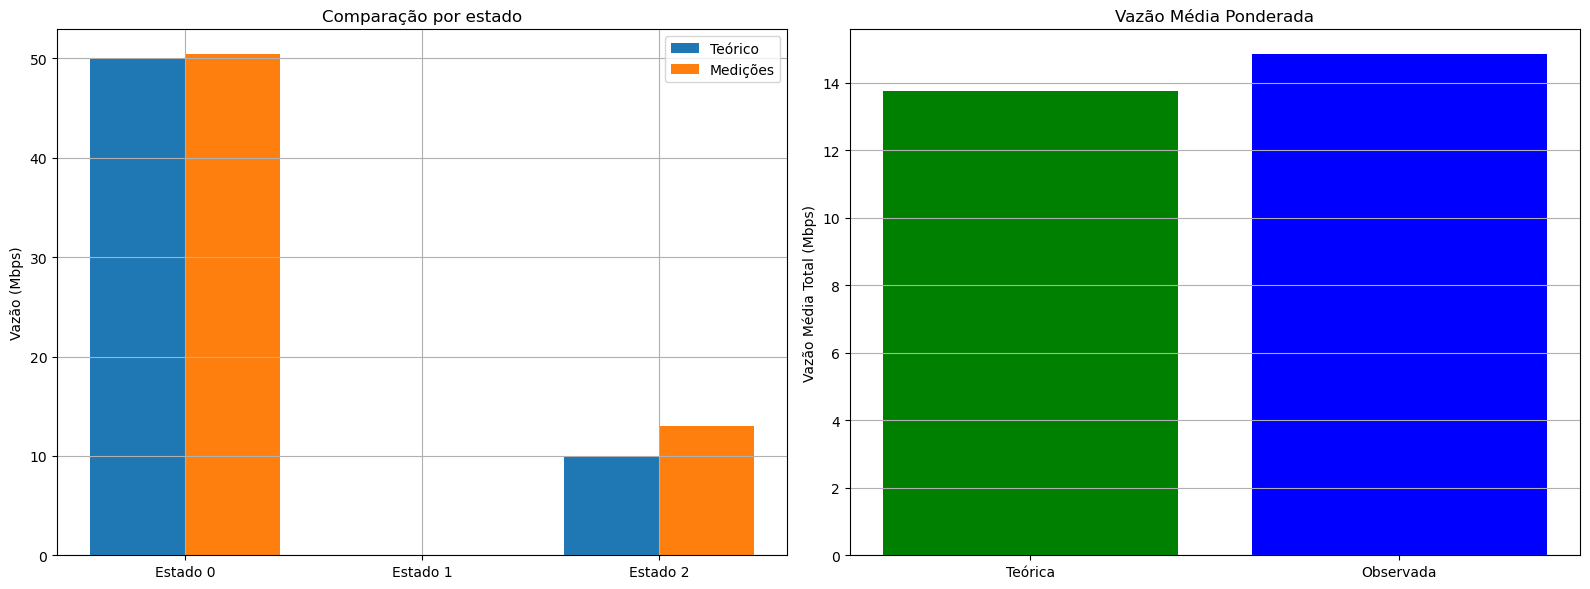

In [99]:
# Saída numérica
print("Distribuição estacionária:", pi)
print("Vazão média teórica:", throughput_theoretical, "Mbps")
print("Vazão média observada:", throughput_observed, "Mbps")

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Comparação por estado
axs[0].bar(range(n_states), bandwidth_theoretical, width=0.4, label="Teórico", align='center')
axs[0].bar(np.arange(n_states) + 0.4, measured_means, width=0.4, label="Medições", align='center')
axs[0].set_xticks(np.arange(n_states) + 0.2)
axs[0].set_xticklabels([f"Estado {i}" for i in range(n_states)])
axs[0].set_ylabel("Vazão (Mbps)")
axs[0].set_title("Comparação por estado")
axs[0].legend()
axs[0].grid(True)

# Plot 2: Vazão média total
axs[1].bar(["Teórica", "Observada"], [throughput_theoretical, throughput_observed], color=["green", "blue"])
axs[1].set_ylabel("Vazão Média Total (Mbps)")
axs[1].set_title("Vazão Média Ponderada")
axs[1].grid(True, axis='y')

plt.tight_layout()
plt.show()
